# Doing Bayesian Data Analysis

An example from __Chapter 18__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

# Kruschke's light blue color
sns.set_palette(["#87ceeb"])
sns.set_context("talk")

In [2]:
df = pd.read_csv("data/18_03_shrinkage.csv")
print len(df)
df.head()

50


,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT,xRand1,xRand2,xRand3,xRand4,xRand5,xRand6,xRand7,xRand8,xRand9,xRand10,xRand11,xRand12
0,Alabama,4.405,17.2,31.144,8,491,538,1029,-0.207901,0.975430,0.697160,-0.461373,-0.372393,-0.586951,0.997585,-0.038980,-0.048534,0.822558,-0.211743,-0.074761
1,Alaska,8.963,17.6,47.951,47,445,489,934,0.037859,-0.263789,-1.292952,-0.467127,0.837334,-0.171516,0.234234,0.032623,-0.384194,-0.780150,-1.644033,0.122416
2,Arizona,4.778,19.3,32.175,27,448,496,944,-0.824948,-0.352708,-2.002454,0.131457,0.228556,0.426742,-0.007733,-0.618603,-0.329469,-1.169190,-1.090921,0.338399
3,Arkansas,4.459,17.1,28.934,6,482,523,1005,-0.302172,-1.623399,1.340380,0.810939,-0.237945,1.281103,-1.897800,-0.054399,2.262594,1.764555,0.189464,0.780980
4,California,4.992,24.0,41.078,45,417,485,902,0.211717,0.459005,-0.325939,0.213267,-0.683693,1.286049,-0.550715,0.611201,0.282367,-0.157777,0.362889,-0.418922


In [3]:
cols = ["Spend", "PrcntTake", "xRand1", "xRand2", "xRand3", "xRand4", "xRand5",
        "xRand6", "xRand7", "xRand8", "xRand9", "xRand10", "xRand11", "xRand12"]
X = df[cols]
y = df["SATT"]

# A little bit convoluted with the two columns
zx = ((X - X.mean().values) / X.std().values).values
zy = (y - y.mean()) / y.std()

n_cols = len(cols)

Kruschke's __Figure 18.10__ diagram of the model:

![Chapter 18.3 model](images/18_10.png)

In [8]:
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, tau=1E-8)

    nu_b = pm.Gamma("nu_b", 2, .1)          # Stan docs recommendation
    sigma_b = pm.HalfCauchy("sigma_b", 25)  # Gelman 2006
    beta_1 = pm.StudentT("beta_1", nu=nu_b, mu=0, sd=sigma_b, shape=n_cols)

    theta = beta_0 + tt.dot(beta_1, zx.T)
    sigma = pm.HalfCauchy("sigma", 25)
    nu = pm.Gamma("nu", 2, .1)

    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    
    # Sample
    step = pm.Metropolis()
    trace = pm.sample(20000, step)
    
burn_in = 10000
trace = trace[burn_in:]

100%|██████████| 20000/20000 [00:10<00:00, 1894.12it/s]


                 mean         sd  mc_error   hpd_2.5   hpd_97.5
beta_0       0.000571   0.060515  0.001611 -0.112322   0.122069
beta_1__0    0.102889   0.068120  0.005316 -0.020502   0.237834
beta_1__1   -0.919987   0.074225  0.005984 -1.067318  -0.776954
beta_1__2    0.018787   0.049194  0.003513 -0.075689   0.123058
beta_1__3   -0.050249   0.050430  0.003414 -0.151631   0.041435
beta_1__4    0.028918   0.051852  0.003694 -0.072531   0.139492
beta_1__5   -0.044302   0.056136  0.004195 -0.161230   0.056100
beta_1__6    0.056147   0.055484  0.004116 -0.038519   0.173990
beta_1__7    0.023058   0.049008  0.003273 -0.067982   0.126112
beta_1__8    0.042596   0.054630  0.003995 -0.063157   0.151522
beta_1__9    0.006715   0.049039  0.003256 -0.084365   0.115596
beta_1__10  -0.043195   0.054746  0.003843 -0.153970   0.056330
beta_1__11  -0.100348   0.066271  0.005143 -0.219633   0.024953
beta_1__12  -0.014401   0.046301  0.002982 -0.117024   0.068349
beta_1__13   0.004559   0.054171  0.0037

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e0e4ad0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121449d10>]], dtype=object)

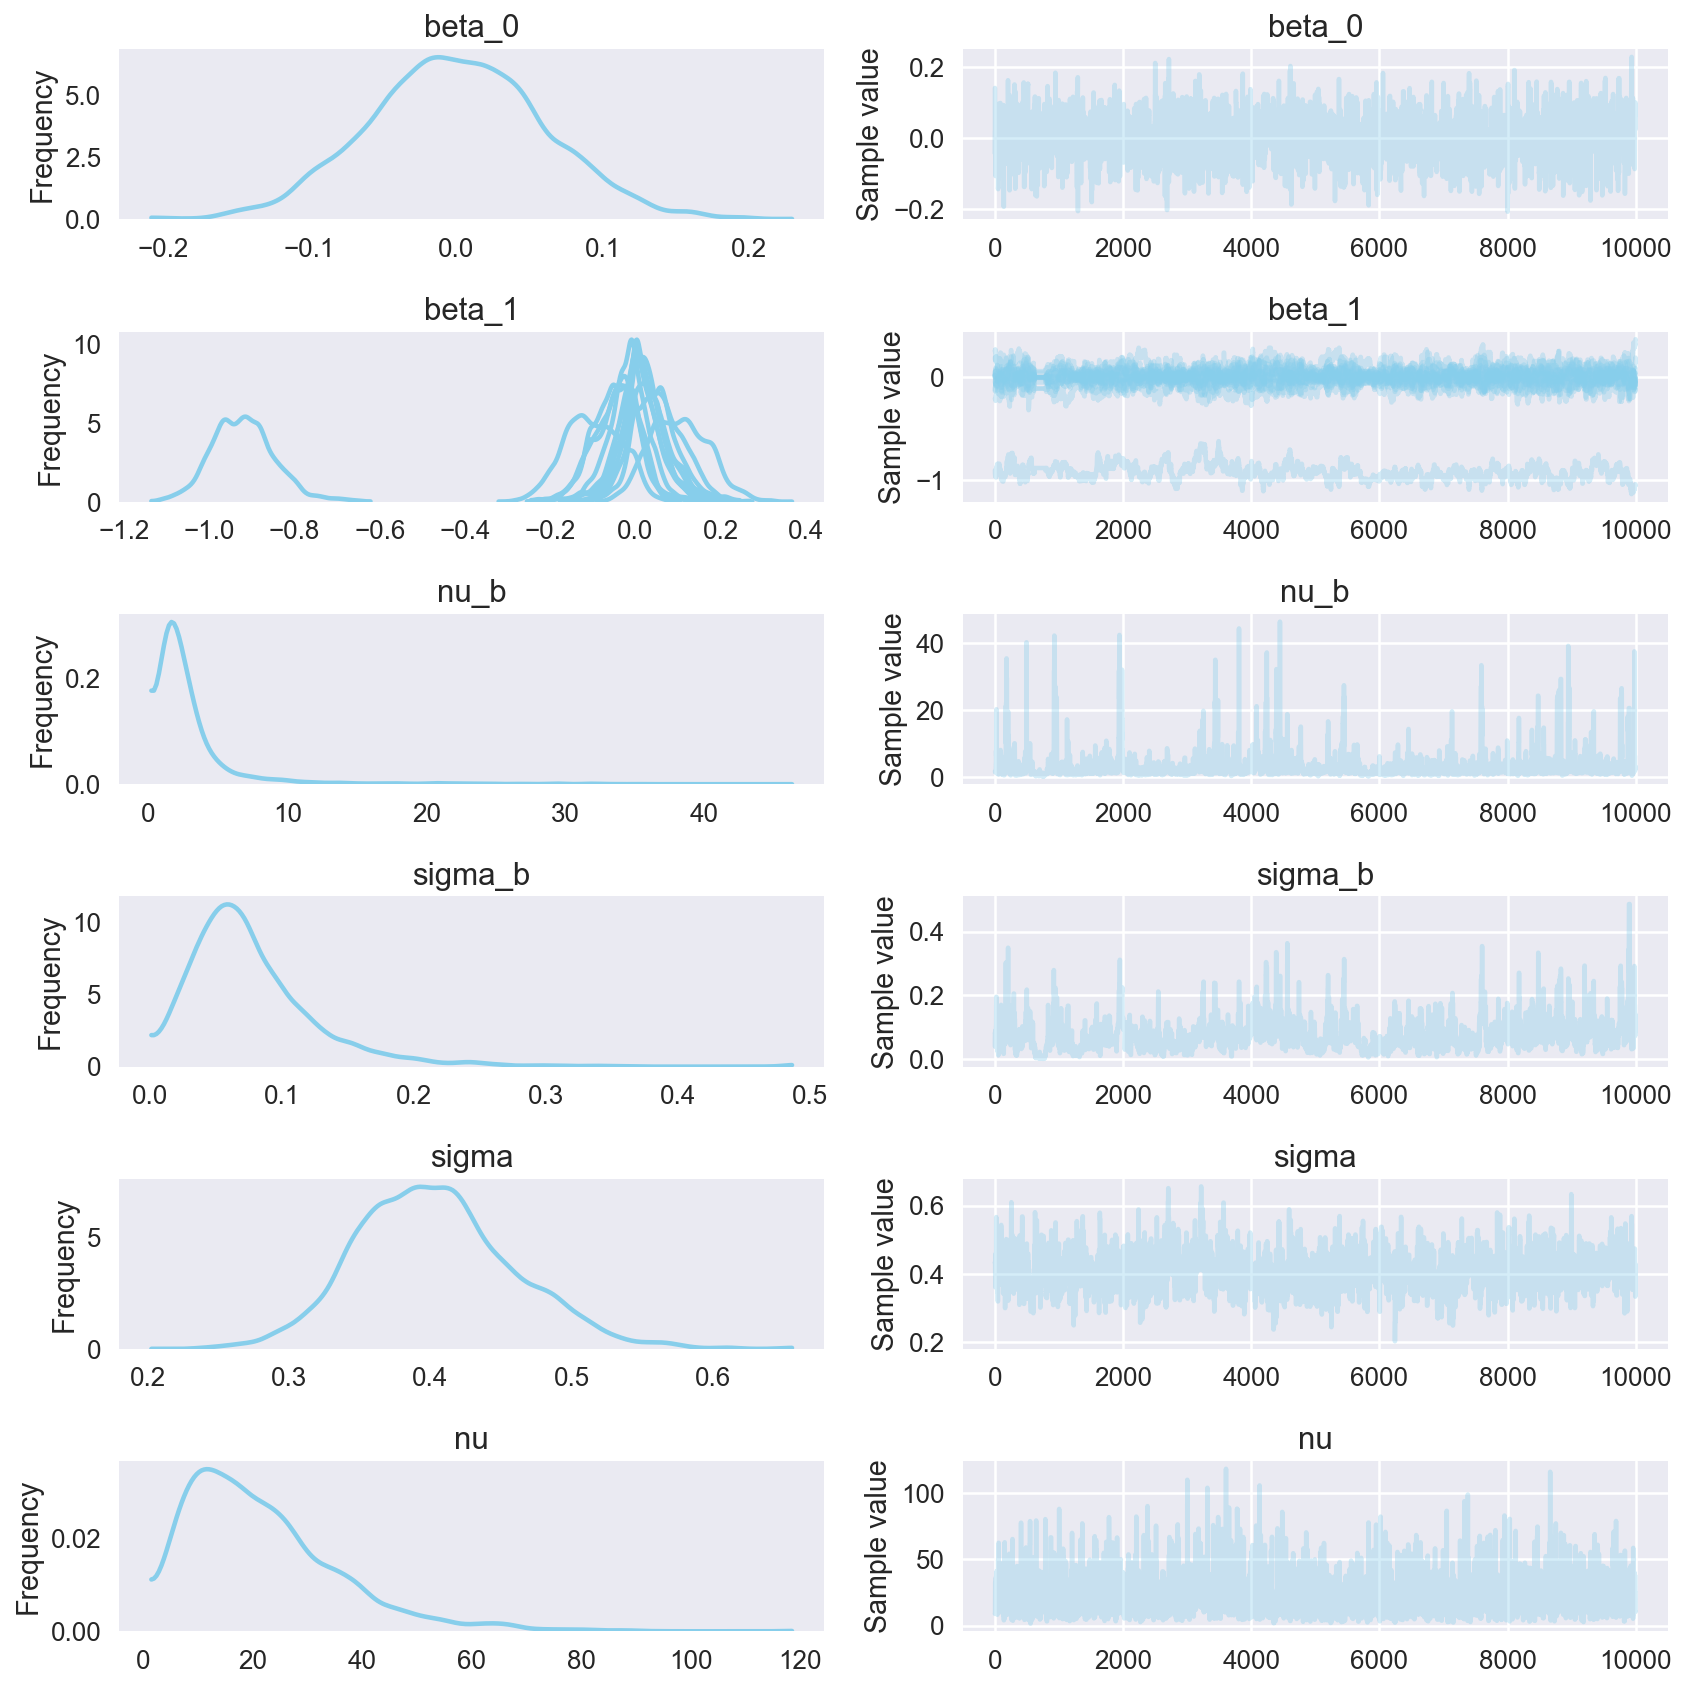

In [9]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1218035d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11e27fc10>], dtype=object)

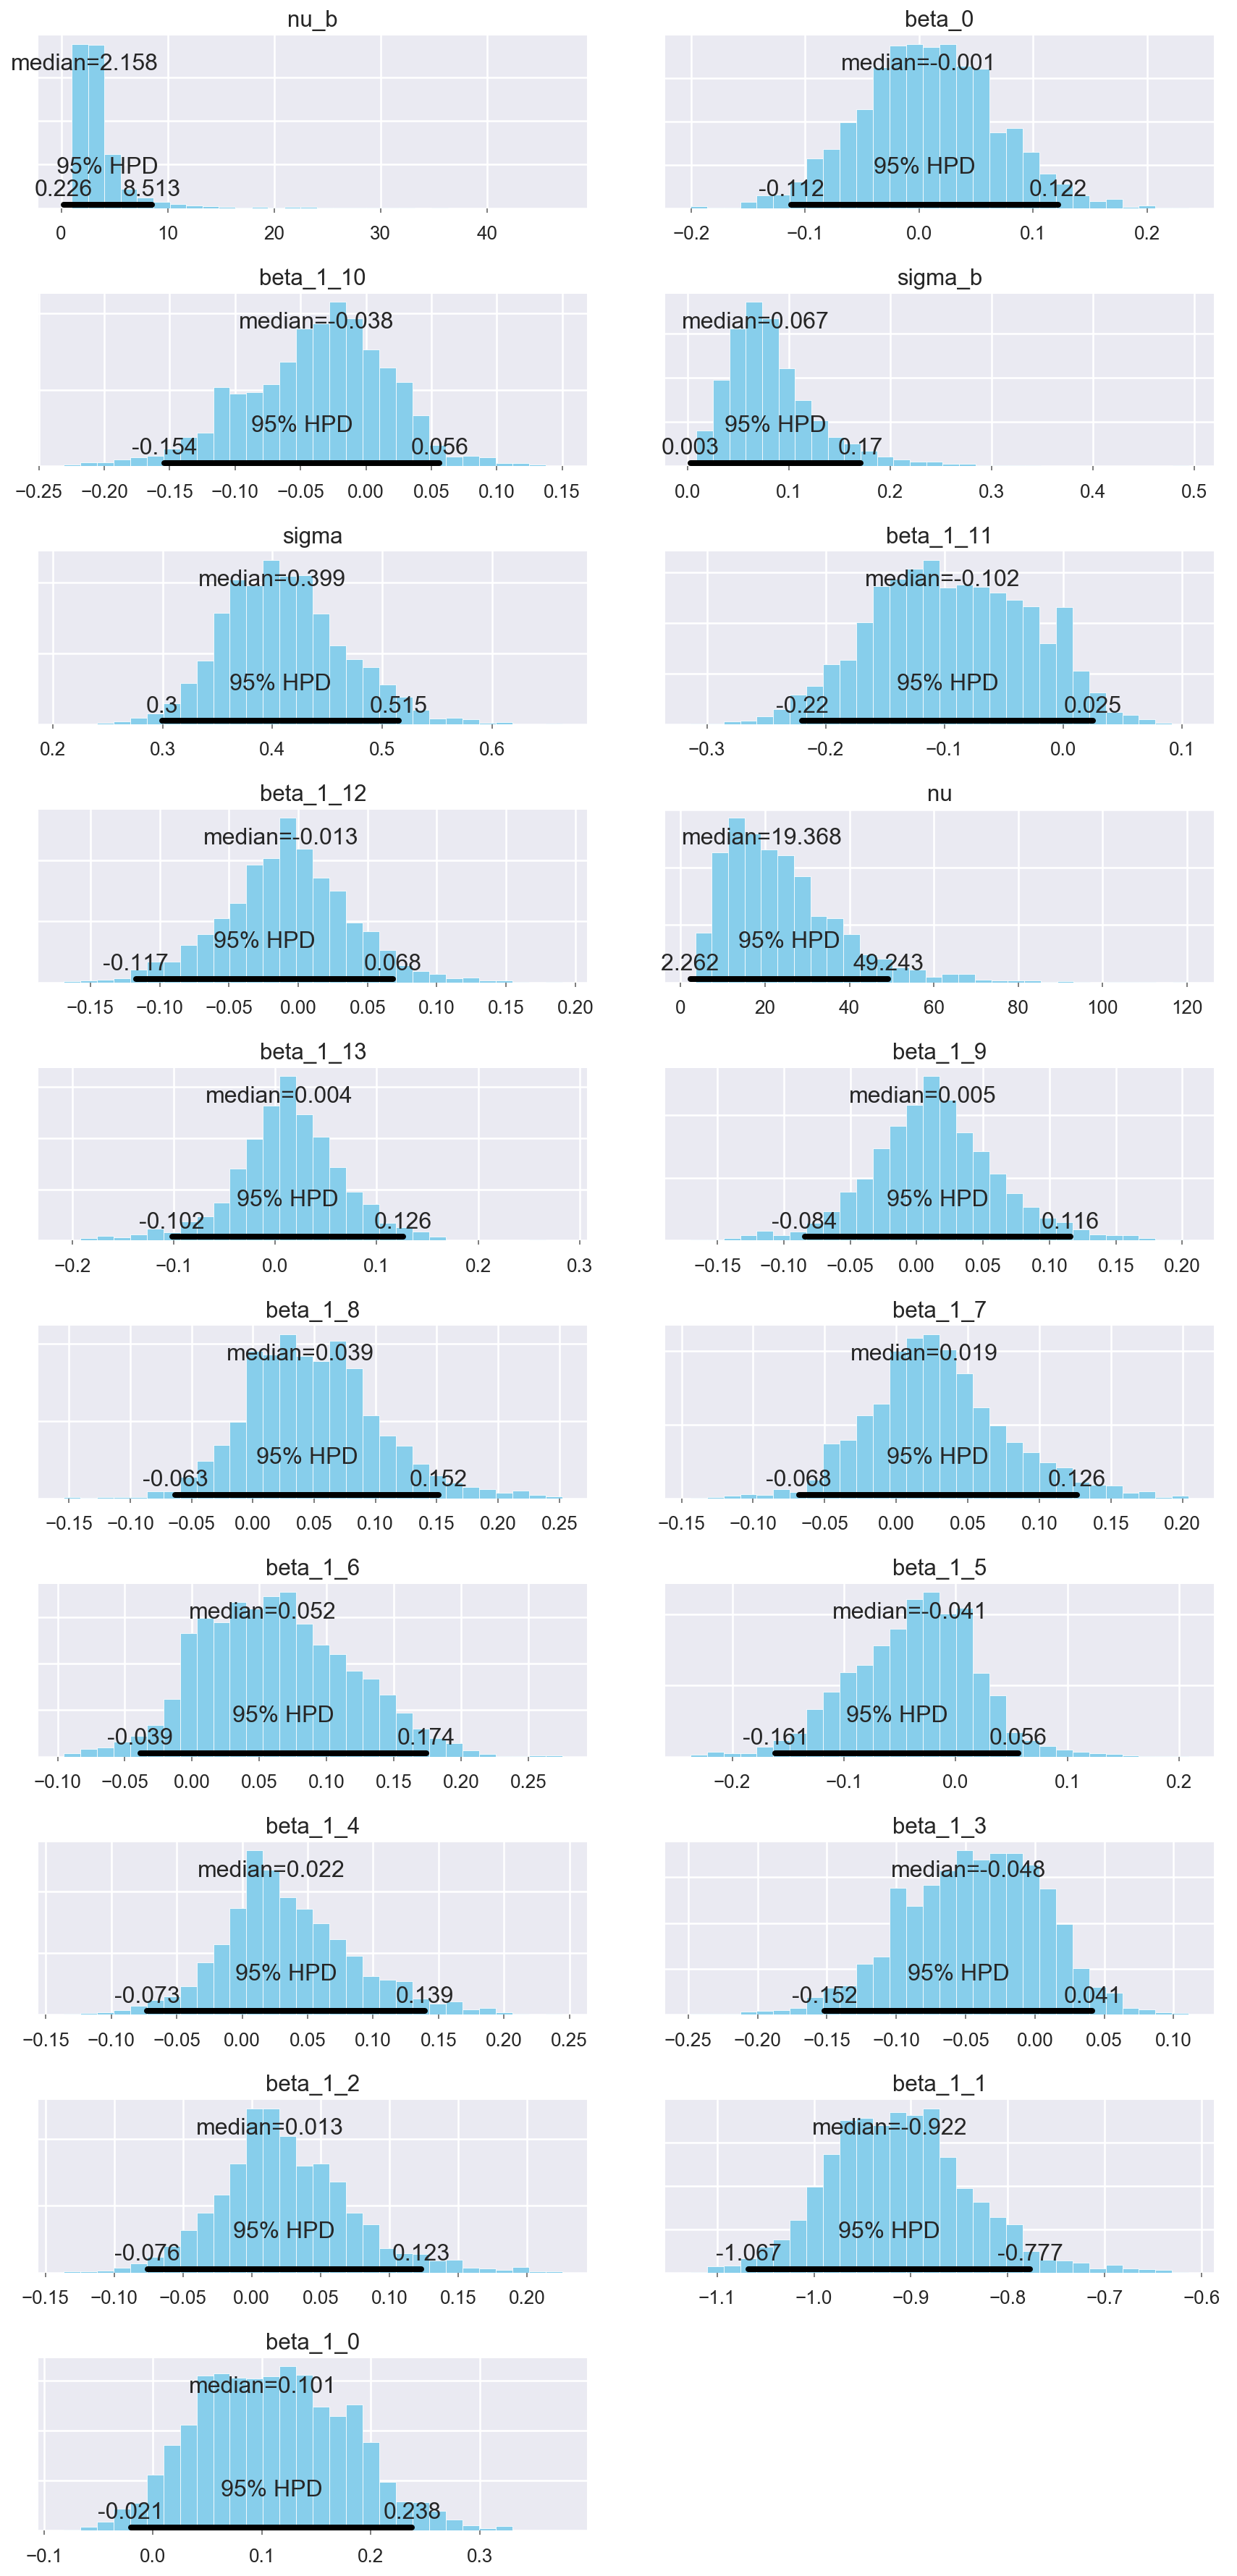

In [10]:
pm.plot_posterior(trace, point_estimate="median")

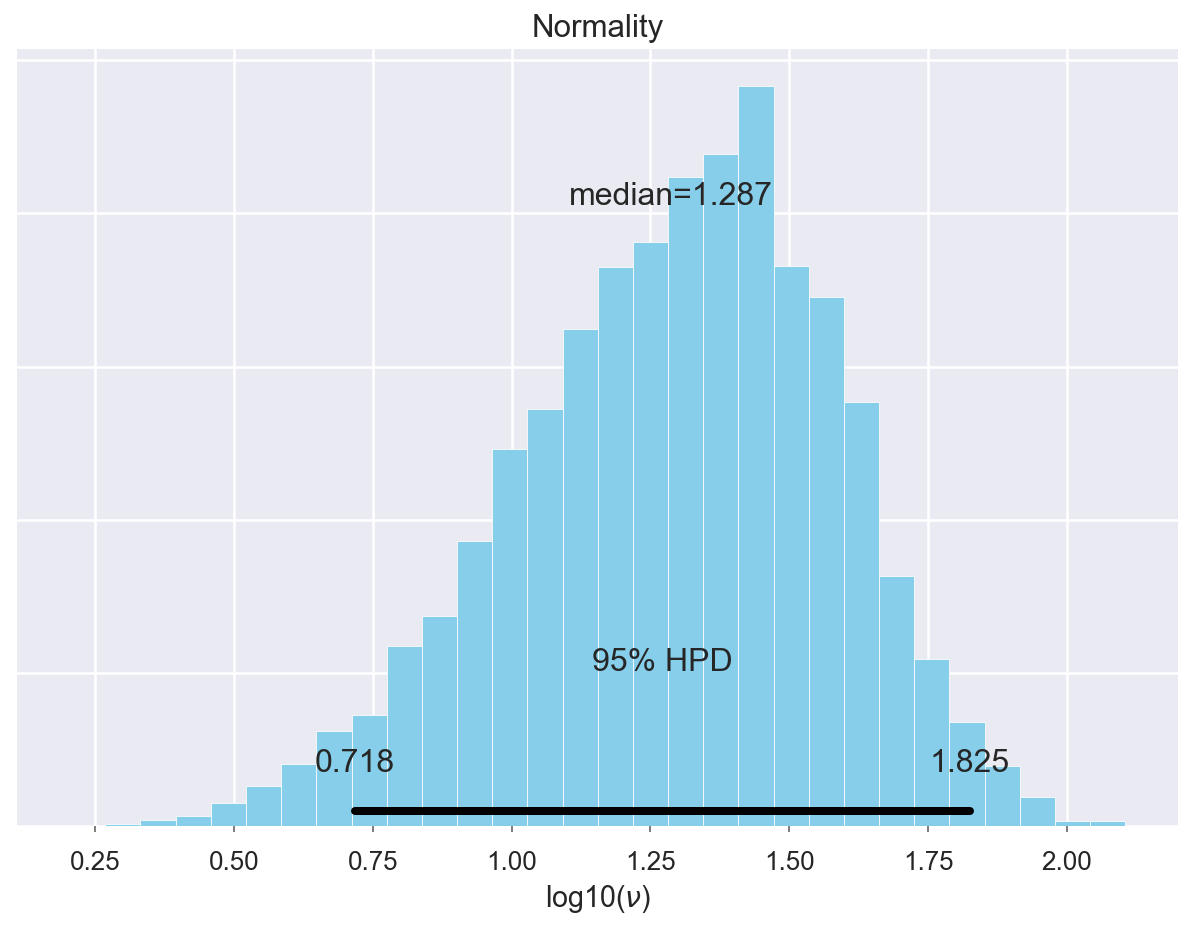

In [11]:
normality = np.log10(trace["nu"])
ax = pm.plot_posterior(normality, point_estimate="median")
ax.set_title("Normality")
ax.set_xlabel(r"log10($\nu$)")